### Initial set-up

#### Google Drive

In [1]:
# Specify if user is working on Google Drive
google_drive = True

In [2]:
if google_drive == True:

    # Authentication Google Drive for desktop
    from google.colab import drive 
    drive.mount('/content/drive')
    
    path = "./drive/MyDrive/TFM/Code/"
    
    import sys
    sys.path.append(path)

else:
    path = "../"
    
    import sys
    sys.path.append(path)

Mounted at /content/drive


#### Google Colab TPU session

In [3]:
# Specify if user is working on a TPU session in Google Colab
tpu_session = True

In [4]:
if tpu_session == True:
    
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    pass

Tensorflow version 2.5.0
Running on TPU  ['10.43.254.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.43.254.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.43.254.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Import libraries

In [5]:
import time
import numpy as np
from functools import reduce

# Import tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Extra utils
from Notebooks.aux_functions.aux_functions_cnn import *

### Load TFRecords

In [6]:
# Specify Google Cloud Storage bucket path where the TFRecords have been saved
gcs_path = 'gs://tfm-kschool-bucket/TFRecords/'

In [7]:
# Authentication Google Cloud SDK
from google.colab import auth
auth.authenticate_user()

#### Load train TFRecords

In [8]:
train_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                                 pattern = "Train/*_train_volumes.tfrecords")

#### Load validation TFRecords

In [9]:
val_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                               pattern = "Validation/*_val_volumes.tfrecords")

#### Load test TFRecords

In [10]:
test_dataset = load_tfr_dataset(tfr_dir = gcs_path,
                                pattern = "Test/*_test_volumes.tfrecords")

#### Check size of training, validation and testing datasets

In [11]:
train_size = reduce(lambda count, item: count + 1, train_dataset, 0)
val_size = reduce(lambda count, item: count + 1, val_dataset, 0)
test_size = reduce(lambda count, item: count + 1, test_dataset, 0)

In [12]:
print(f"[+] Training size:", train_size)
print(f"[+] Validation size:", val_size)
print(f"[+] Testing size:", test_size)

[+] Training size: 759
[+] Validation size: 163
[+] Testing size: 163


### Preprocessing

In [13]:
# Specify inputs
#batch_size = 8 * tpu_strategy.num_replicas_in_sync
batch_size = 32

In [14]:
train_dataset = train_dataset.batch(batch_size).prefetch(1)
val_dataset = val_dataset.batch(batch_size).prefetch(1)
test_dataset = val_dataset.batch(batch_size).prefetch(1)

### Convolutional Neural Network

#### Define Neural Network

In [29]:
np.random.seed(123)
tf.random.set_seed(123) 

In [ ]:
def build_model_3d(model_name, input_shape):
    '''
    Build a 3D Convolutional Neural Network (CNN).
    '''

    # Fix random seed for reproducibility
    np.random.seed(123)
    tf.random.set_seed(123) 
    
    ## Input layer
    inputs = Input(shape = input_shape + (1,))
    
    ## Convolutional blocks
    # 1st conv block
    x = Conv3D(64, kernel_size = 3, activation = 'relu')(inputs)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
              
    # 2nd conv block
    x = Conv3D(128, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 3rd conv block
    x = Conv3D(256, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)

    # 4rd conv block
    x = Conv3D(512, kernel_size = 3, activation = 'relu')(x)
    x = MaxPool3D(pool_size = 2)(x)
    x = BatchNormalization()(x)
    
    ## Flatten layer
    x = GlobalAveragePooling3D()(x)
              
    ## Dense layers       
    x = Dense(512, activation = "relu")(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation = "relu")(x)
    x = Dropout(0.3)(x)

    ## Output layer
    outputs = Dense(1, activation = "sigmoid")(x)

    # Define the model
    model = Model(inputs, outputs)
    
    # Name model
    model._name = model_name
    
    return model

#### Build new CNN model

In [ ]:
# Define inputs
model_name = "3d_model_v4"
input_shape = (110, 130, 80) # (78, 100, 86) , (180, 180, 110)

In [ ]:
# Define learning rate
lr_initial = 0.001

lr_schedule = ExponentialDecay(lr_initial, 
                               decay_steps = 100000, 
                               decay_rate = 0.96, 
                               staircase = True)

In [22]:
# Define optimizer
#optimizer =  SGD(learning_rate = 0.1)  # from 0.0001 to 0.1
optimizer = Adam(learning_rate = 0.001, decay = 1e-6)

In [ ]:
# TPU strategy
with tpu_strategy.scope(): 
    
    # Build mode
    model = build_model_3d(model_name, input_shape)

    # Compile model
    model.compile(loss = "binary_crossentropy",
                  optimizer = optimizer,
                  metrics = [BinaryAccuracy(), f1])

#model.summary()

#### Setup callbacks

**EarlyStopping** in this case tracks the val_loss value, stops the training if there are no changes towards val_loss after 3 epochs, and keeps the best weights once the training stops.

In [ ]:
callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0,
                                        patience = 3,
                                        verbose = 1,
                                        restore_best_weights = True)

**ModelCheckpoint** saves the best model in the folder Results. It tracks the metric val_loss and saves the model after each epoch only if val_loss has been reduced in compared to the previous model saved.

In [ ]:
callback_checkpoint = ModelCheckpoint(path + "Results/" + model.name + ".h5",
                                      monitor = 'val_loss',
                                      mode = 'min',
                                      save_best_only = True,
                                      verbose = 1)

#### Train CNN model

In [ ]:
steps_per_epoch = int(train_size / batch_size)
val_steps = int(val_size / batch_size)

print(f"Steps per epoch: {steps_per_epoch}, validation steps: {val_steps}")

Steps per epoch: 23, validation steps: 5


In [ ]:
# Train model
start_time = time.time()

history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = val_dataset,
                    verbose = 1,
                    callbacks = [callback_checkpoint])

end_time = time.time()
print("\n[+] Time of training: "+"{:.2f}".format(end_time-start_time));

Epoch 1/100
24/24 [==============================] - 73s 2s/step - loss: 0.7075 - binary_accuracy: 0.6113 - f1: 0.5783 - val_loss: 1.0428 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.04279, saving model to ./drive/MyDrive/TFM/Code/Results/3d_model_v4.h5
Epoch 2/100
24/24 [==============================] - 29s 744ms/step - loss: 0.6589 - binary_accuracy: 0.6113 - f1: 0.5725 - val_loss: 0.9818 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00

Epoch 00002: val_loss improved from 1.04279 to 0.98176, saving model to ./drive/MyDrive/TFM/Code/Results/3d_model_v4.h5
Epoch 3/100
24/24 [==============================] - 28s 670ms/step - loss: 0.6533 - binary_accuracy: 0.6206 - f1: 0.5775 - val_loss: 1.8030 - val_binary_accuracy: 0.4724 - val_f1: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.98176
Epoch 4/100
24/24 [==============================] - 32s 822ms/step - loss: 0.6324 - binary_accuracy: 0.6509 - f1: 0.5832 - val_loss: 2.6

#### Load existing CNN model

In [30]:
model_name = "3d_model_v4"

In [31]:
# Load model
model_loaded = load_model(path + "Results/" + model_name + ".h5", 
                   custom_objects = {'f1': f1})

print("[+] Model loaded")
#model.summary()

[+] Model loaded


In [32]:
    # Compile model
model_loaded.compile(loss = "binary_crossentropy",
                  optimizer = optimizer,
                  metrics = [BinaryAccuracy(), f1])

In [ ]:
# Load model history
history_loaded = np.load(path + "Results/" + model_name + "_history.npy", 
                  allow_pickle = 'TRUE').item()

print("[+] Model history loaded")

### Evaluation 

#### Metrics

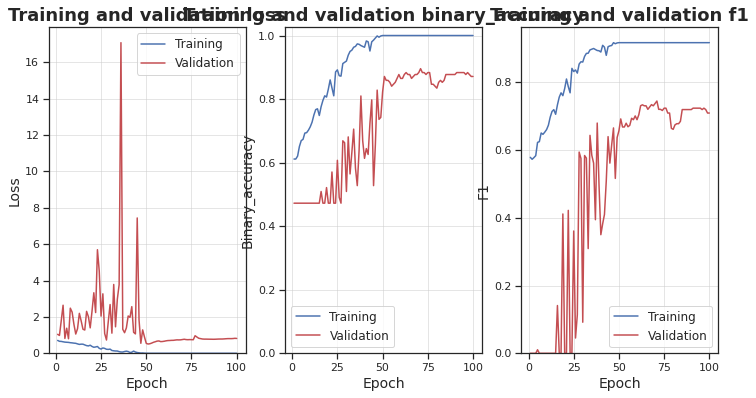

In [ ]:
# Plot metrics
plot_history(history)

In [ ]:
# Plot roc curve
plot_roc_curve(model, X_train, X_test, y_train, y_test, save_fig = False)

In [33]:
# Get accuracy
model_loaded.evaluate(train_dataset,
                      verbose = 0)

[0.051787663251161575, 0.9749670624732971, 0.9751615524291992]

#### Evaluation training dataset

In [34]:
# Get true labels
true_labels = list(reduce(lambda a, b: np.concatenate((a, b), axis=0), [y.numpy() for x, y in train_dataset]))

In [35]:
# Get predictions
predicted_labels = list(reduce(lambda a, b: np.concatenate((a, b), axis=0), model_loaded.predict(train_dataset)))
predicted_labels = list(map(lambda x: 1 if x > 0.5 else 0, predicted_labels))

In [ ]:
predicted_labels_2 = list(reduce(lambda a, b: np.concatenate((a, b), axis=0), model.predict(train_dataset)))

In [ ]:
predicted_labels_2[:10]

[0.9992967,
 0.99975955,
 1.0,
 0.9936583,
 0.97686815,
 0.99939334,
 0.9793111,
 0.9997724,
 0.9993502,
 0.99993896]

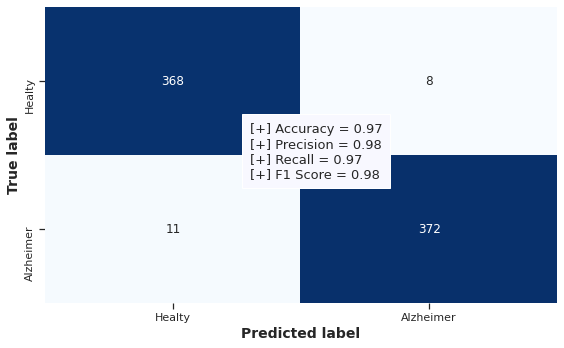

In [36]:
# Get evaluation 
get_evaluation(true_labels, predicted_labels)

#### Evaluation testing dataset

In [ ]:
# Get true labels
true_labels = list(reduce(lambda a, b: np.concatenate((a, b), axis=0), [y.numpy() for x, y in test_dataset]))

InvalidArgumentError: ignored

In [ ]:
# Get true labels
true_labels = list(reduce(lambda a, b: np.concatenate((a, b), axis=0), [y.numpy() for x, y in test_dataset]))

InvalidArgumentError: ignored

In [ ]:
# Get predictions
predicted_labels = []

for sample in test_dataset:

  volume_ = sample[0].numpy()
  volume_ = np.reshape(volume_, (1, 110, 130, 80))
  predicted_labels.append(model.predict(volume_))

predicted_labels = list(map(lambda x: 1 if x > 0.5 else 0, predicted_labels))

In [ ]:
true_labels = []

for sample in test_dataset:

  label_ = sample[1].numpy()

  true_labels.append(label_)

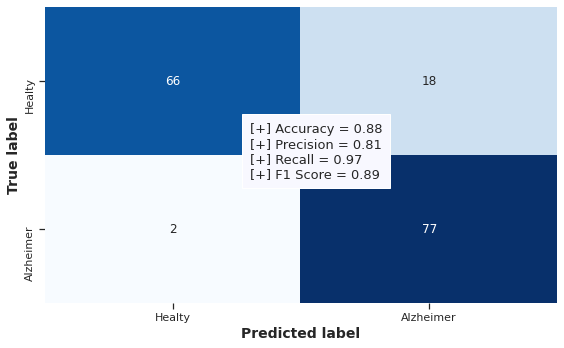

In [ ]:
# Get evaluation 
get_evaluation(true_labels, predicted_labels)

#### Save CNN model

In [ ]:
# Save CNN model
model.save(path + "Results/" + model.name + ".h5")

print("[+] Model saved")

# Save CNN model history
np.save(path + "Results/" + model.name + "_history.npy", history.history)

print("[+] Model history saved")

[+] Model saved
[+] Model history saved


### CNN Visualization

In [37]:
from vis.visualization import visualize_saliency

ImportError: ignored

In [39]:
from scipy.misc import imresize

ImportError: ignored

In [40]:
from vis.visualization import visualize_saliency

ImportError: ignored